<a href="https://colab.research.google.com/github/Deep-Learning-Qatar/EEG-Vision/blob/main/Data_preparation_EEGVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import matplotlib.pyplot as plt
import random

In [ ]:
cuda = torch.cuda.is_available()
print('Cuda:', cuda)

Cuda: False


# EEG Data Organisation

In [ ]:
# Download data from here: https://studentiunict-my.sharepoint.com/personal/concetto_spampinato_unict_it/_layouts/15/onedrive.aspx?originalPath=aHR0cHM6Ly9zdHVkZW50aXVuaWN0LW15LnNoYXJlcG9pbnQuY29tLzpmOi9nL3BlcnNvbmFsL2NvbmNldHRvX3NwYW1waW5hdG9fdW5pY3RfaXQvRXRNd2Z2cmNUV2xBcVRJV3RSNEs1Q3dCSmtsdk1EUG9UY242dGJYYllNNE5uZz9ydGltZT05ZnJtZjZ6MzJFZw&id=%2Fpersonal%2Fconcetto%5Fspampinato%5Funict%5Fit%2FDocuments%2FSito%20PeRCeiVe%2Fdatasets%2Feeg%5Fcvpr%5F2017%2Fdata
data_path = '/content/gdrive/MyDrive/11-785 Deep Learning/Project/eeg_55_95_std.pth'
data_dict = torch.load(data_path)
data_dict.keys()

dict_keys(['dataset', 'labels', 'images'])

In [ ]:
# Load data and create dataset for each split
def split_train_val_test(data_dict, splits=(0.8, 0.1, 0.1)):

    # Find all possible image IDs
    image_ids = set()
    for di in data_dict['dataset']:
        image_ids.add(di['image'])
    # print(len(image_ids))

    # Organise data by image (key: image ID, val: list of data dicts with all data)
    data_by_image = dict()
    for id in image_ids:
        data_by_image[id] = []
    for di in data_dict['dataset']:
        image_id = di['image']
        data_by_image[image_id].append(di)

    # Shuffle data so selection for splits are random
    image_ids_li = list(image_ids)
    random.shuffle(image_ids_li)
    data_by_image = {id: data_by_image[id] for id in image_ids_li}
    
    # Create val and test sets
    data_len = len(image_ids_li)
    val_len, test_len = int(splits[1]*data_len), int(splits[2]*data_len)
    val_data, test_data = dict(), dict()
    for i in range(val_len):
        k, v = data_by_image.popitem()
        val_data[k] = v
    for i in range(test_len):
        k, v = data_by_image.popitem()
        test_data[k] = v
    train_data = data_by_image
    # print(train_data.keys())
    # print(val_data.keys())
    # print(test_data.keys())
    
    # Return all sets
    return train_data, val_data, test_data

In [ ]:
# TODO: Make a split function where a number of classes are kept away from training

In [ ]:
# General data set for EEG data dictionary
class EEGDataSet(data.Dataset):
    """
    Possible labels: eeg, label (ID), image (ID), subject
    Interval indicates what section of the ~500ms EEG signal should be returned
    """
    def __init__(self, data_dict, x_label='eeg', y_label='label', interval=(20, 460)):
        dl = list(data_dict.values())
        self.data_list = [item for sublist in dl for item in sublist]
        self.length = len(self.data_list)
        self.interval = interval
        self.x_label = x_label
        self.y_label = y_label
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        data_entry = self.data_list[index]
        x = data_entry[self.x_label]
        if self.x_label == 'eeg':
            x = x[:, self.interval[0]:self.interval[1]]
            x = torch.transpose(x, 0, 1)
        else:
            x = torch.as_tensor(x).float()
        y = data_entry[self.y_label]
        if self.y_label == 'eeg':
            y = y[:, self.interval[0]:self.interval[1]]
            y = torch.transpose(y, 0, 1)
        else:
            y = torch.as_tensor(y).long()
        return x, y

In [ ]:
train_data, val_data, test_data = split_train_val_test(data_dict)

In [ ]:
train_dataset = EEGDataSet(train_data)
train_loader_args = dict(shuffle=True, batch_size=16, num_workers=2) if cuda\
                    else dict(shuffle=True, batch_size=16)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

val_dataset = EEGDataSet(val_data)
val_loader_args = dict(shuffle=False, batch_size=16, num_workers=2) if cuda\
                    else dict(shuffle=False, batch_size=16)
val_loader = data.DataLoader(val_dataset, **val_loader_args)

test_dataset = EEGDataSet(test_data)
test_loader_args = dict(shuffle=False, batch_size=16, num_workers=2) if cuda\
                    else dict(shuffle=False, batch_size=16)
test_loader = data.DataLoader(test_dataset, **test_loader_args)

In [ ]:
# Check if loader works
for i, d in enumerate(train_loader):
    if i == 0:
        print(d[0].shape)
        print(d[1])
        break

# Correct output: 
# torch.Size([16, 440, 128])
# tensor([ list with 16 values between 0 and 39 ])

torch.Size([16, 440, 128])
tensor([27, 10, 27,  5, 23,  4,  7, 34, 11,  2,  3, 31,  6, 33,  2, 38])


In [ ]:
# Save datasets
%cd /content/gdrive/MyDrive/11-785 Deep Learning/Project
EEG_datasets = dict(train=train_data, val=val_data, test=test_data)

torch.save(EEG_datasets, 'EEG_datasets.pth')

/content/gdrive/MyDrive/11-785 Deep Learning/Project


In [ ]:
# TODO: Make function to do hemisphere lateralization

# ImageNet Data Organisation

## Extract images we need
(done on AWS EC2 instance after download the Kaggle ImageNet dataset)

In [ ]:
import torch
import os
import pickle

In [ ]:
data_path = '/home/ubuntu/competitions/image_list.txt'
with open(data_path, "rb") as fp:
    image_list = pickle.load(fp)
print(image_list[:5])

In [ ]:
import os.path
from os import path
from PIL import Image
from torchvision.transforms import ToTensor

def get_image_using_name(name):
    res = None
    [dir, f] = name.split('_')
    img_path = '/home/ubuntu/competitions/imagenet-object-localization-challenge/train/'+dir+'/'+name+'.JPEG'
    check = path.isfile(img_path)
    if check:
        img = Image.open(img_path)
        res = ToTensor()(img)
    return res

In [ ]:
image_list = data_dict['images']
data_by_image = dict()
images_not_found = dict()
for i in range(len(image_list)):
    data_by_image[i] = None
cnt = 0
for i, image_name in enumerate(image_list):
    image_res = get_image_using_name(image_name)
    if image_res != None:
        cnt += 1
        data_by_image[i] = image_res
    else:
        images_not_found[i] = image_name

print('Found', cnt, 'images out of', len(image_list), 'total images needed')     

['n02951358_31190',
 'n03452741_16744',
 'n04069434_10318',
 'n02951358_34807',
 'n03452741_5499']

In [ ]:
# Save dictionary with images
torch.save(data_by_image, 'data_by_image.pth')
torch.save(images_not_found, 'images_not_found.pth')

## Create dataset for images
Find the most up-to-date version in Image-Net notebook

In [ ]:
# %cd /content/gdrive/MyDrive/11-785 Deep Learning/Project
# !unzip out.zip

/content/gdrive/MyDrive/11-785 Deep Learning/Project
Archive:  out.zip
  inflating: data_by_image.pth       


In [ ]:
# Load image data
data_by_image = torch.load('/content/gdrive/MyDrive/11-785 Deep Learning/Project/data_by_image.pth')

# Make EEG dataset dictionary
EEG_datasets = dict(train=train_data, val=val_data, test=test_data)

In [ ]:
# Convert images back to PIL to be able to transform (crop)
from PIL import Image
from torchvision import transforms
data_by_images = {i: transforms.ToPILImage()(data_by_images[i]).convert("RGB") for i in data_by_images}

In [ ]:
# Create dataset for Images using EEG data
class ImageDataset(data.Dataset):
    def __init__(self, image_data, EEG_data, transform):
        self.image_data = image_data
        self.EEG_data = EEG_data
        self.image_ids = list(EEG_data.keys())
        self.transform = transform
        self.length = len(self.image_ids)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image = self.transform(self.image_data[image_id])
        label = self.EEG_data[image_id][0]['label']
        return image, label

In [ ]:
input_size = 244

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
train_image_dataset = ImageDataset(data_by_image, EEG_datasets['train'], data_transforms['train'])
train_image_loader_args = dict(shuffle=True, batch_size=64, num_workers=2) if cuda\
                    else dict(shuffle=True, batch_size=64)
train_image_loader = data.DataLoader(train_image_dataset, **train_image_loader_args)

val_image_dataset = ImageDataset(data_by_image, EEG_datasets['val'], data_transforms['val'])
val_image_loader_args = dict(shuffle=False, batch_size=64], num_workers=2) if cuda\
                    else dict(shuffle=False, batch_size=64)
val_image_loader = data.DataLoader(val_image_dataset, **val_image_loader_args)

test_image_dataset = ImageDataset(data_by_image, EEG_datasets['test'], data_transforms['val'])
test_image_loader_args = dict(shuffle=False, batch_size=64, num_workers=2) if cuda\
                    else dict(shuffle=False, batch_size=64)
test_image_loader = data.DataLoader(test_image_dataset, **test_image_loader_args)

dataloaders_dict = dict(
    train=train_image_loader,
    val=val_image_loader,
    test= test_image_loader,
)

del EEG_datasets
del data_by_image

## Image transform checks

Not sure if the normalization is a good idea for the images but the resizing and center cropping works well

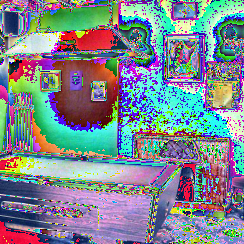

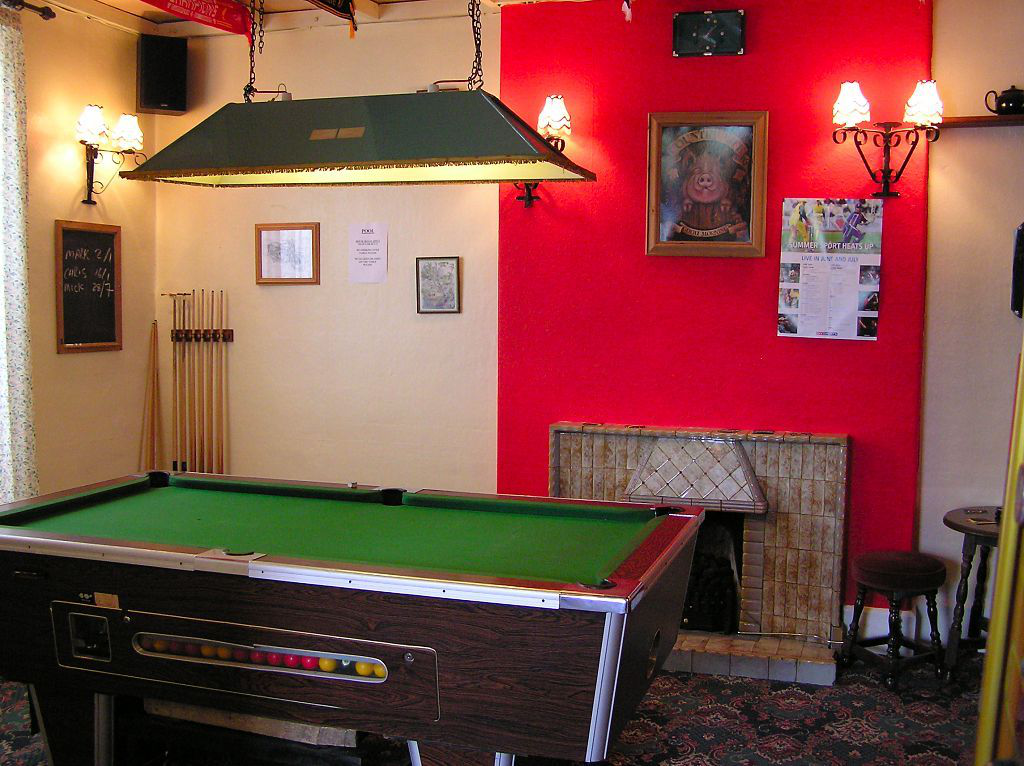

In [ ]:
img = val_image_dataset[0][0]
display(transforms.ToPILImage()(img).convert("RGB"))
display(data_by_image[val_dataset.data_list[0]['image']])